In [1]:
import pandas as pd
import csv
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import numpy as np
from scipy import stats  


c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


*Flavornet data*

In [2]:
# only using flavornet data
mol_to_OD = {}
CAS_OD = {}
molecules = []
descriptors = []
with open('./data/CAS_mol_OD.csv', 'r',encoding='utf-8') as tabfile:
    reader = csv.reader(tabfile, delimiter=',')
    for row in reader: 
        molecule = row[0]
        CAS = row[1]
        OD = row[3]
        molecules.append(molecule)
        descriptors.append(OD)
        if CAS in mol_to_OD:
            mol_to_OD[CAS].add(OD)
        else:
            mol_to_OD[CAS]  = set([OD])

molecules = list(set(molecules))
descriptors = list(set(descriptors))

In [3]:
# key = CAS (727), value = odorant (197)
# 727 cas numbers
mol_to_OD

{'6485-40-1': {'mint'},
 '3033-23-6': {'rose', 'sweet'},
 '21284-22-0': {'green tea', 'herb', 'spice'},
 '38427-78-0': {'terpentine'},
 '495-61-4': {'balsamic'},
 '29873-99-2': {'green', 'oil', 'wood'},
 '6909-30-4': {'green'},
 '99-49-0': {'basil', 'caraway', 'fennel', 'mint'},
 '2244-16-8': {'caraway'},
 '876-17-5': {'flower', 'green'},
 '5989-27-5': {'citrus', 'mint'},
 '4674-50-4': {'grapefruit'},
 '2243-33-6': {'dill'},
 '10307-61-6': {'apple'},
 '69064-37-5': {'oil'},
 '85761-70-2': {'green', 'leaf'},
 '6728-26-3': {'apple', 'fat', 'green', 'leaf', 'rancid'},
 '13419-69-7': {'fat', 'must'},
 '928-95-0': {'green', 'leaf', 'walnut'},
 '18829-56-6': {'cucumber', 'fat', 'green'},
 '1576-96-1': {'mushroom'},
 '53448-07-0': {'fat', 'green', 'soap'},
 '928-97-2': {'fresh', 'moss'},
 '1197-07-5': {'caraway', 'solvent'},
 '14371-10-9': {'cinnamon', 'paint'},
 '09.04.5948': {'herb', 'warm'},
 '106-28-5': {'muguet'},
 '5273-85-8': {'flower', 'spice'},
 '5932-68-3': {'flower'},
 '4959-35-7':

*Research data*

In [4]:
Research_data = pd.read_csv('./data/swri_flavorwheel.csv', sep=';')
OSA_research = Research_data['OSA'].unique()
OQ_research = Research_data['OQ'].unique()
OD_research = Research_data['OD'].unique()

In [5]:
Research_OD_OSA = Research_data.drop(columns=Research_data.columns[1])

#### create matrix with CAS OD and OSA

In [6]:
flavors_list = []

for cas, flavors in mol_to_OD.items():
    for flavor in flavors:
        flavors_list.append({'CAS': cas, 'OD': flavor})

CAS_OD = pd.DataFrame(flavors_list)

In [7]:
# Function to perform fuzzy matching
def fuzzy_match(row, df):
    matches = df[df['OD'].apply(lambda x: fuzz.partial_token_set_ratio(row['OD'], str(x).lower())) >= 80]
    if len(matches) == 1:
        return pd.Series([row['CAS'], matches.iloc[0]['OD'], matches.iloc[0]['OSA']])
    elif len(matches) > 1:
        best_match = matches.iloc[matches['OD'].apply(lambda x: fuzz.ratio(row['OD'], str(x).lower())).argmax()]
        return pd.Series([row['CAS'], best_match['OD'], best_match['OSA']])
    else:
        return pd.Series([row['CAS'], row['OD'], None])

# Apply fuzzy matching
result_df = CAS_OD.apply(lambda x: fuzzy_match(x, Research_OD_OSA), axis=1)
result_df.columns = ['CAS', 'OD', 'OSA']

In [8]:
# remove Nones
result_df = result_df.dropna()
print(result_df)

              CAS             OD           OSA
1       3033-23-6          Roses        Floral
2       3033-23-6          Sweet         Sweet
3      21284-22-0          Spicy         Spicy
4      21284-22-0  Green peppers  Green/grassy
5      21284-22-0    Fresh herbs  Green/grassy
...           ...            ...           ...
1331    2825-91-4   coconut milk         Nutty
1332     713-95-1         Fruity        Fruity
1333     713-95-1          Sweet         Sweet
1334   20307-84-0          Woody         Woody
1335  120021-96-7           Oily          Oily

[993 rows x 3 columns]


In [9]:
len(set(result_df['CAS']))

596

In [10]:
# Function to perform fuzzy matching
def fuzzy_match_all(row, df):
    matches = df[df['OD'].apply(lambda x: fuzz.partial_token_set_ratio(row['OD'], str(x).lower())) >= 80]
    if len(matches) == 1:
        return pd.Series([row['CAS'], row['OD'], matches.iloc[0]['OD'], matches.iloc[0]['OSA']])
    elif len(matches) > 1:
        best_match = matches.iloc[matches['OD'].apply(lambda x: fuzz.ratio(row['OD'], str(x).lower())).argmax()]
        return pd.Series([row['CAS'],row['OD'], best_match['OD'], best_match['OSA']])
    else:
        return pd.Series([row['CAS'], row['OD'], None, None])

# Apply fuzzy matching
result_df_all = CAS_OD.apply(lambda x: fuzzy_match_all(x, Research_OD_OSA), axis=1)
result_df_all.columns = ['CAS', 'odorants', 'OD', 'OSA']

print(result_df_all)


              CAS   odorants             OD           OSA
0       6485-40-1       mint           None          None
1       3033-23-6       rose          Roses        Floral
2       3033-23-6      sweet          Sweet         Sweet
3      21284-22-0      spice          Spicy         Spicy
4      21284-22-0  green tea  Green peppers  Green/grassy
...           ...        ...            ...           ...
1334   20307-84-0       wood          Woody         Woody
1335  120021-96-7        oil           Oily          Oily
1336     586-62-9    plastic           None          None
1337     586-62-9       pine           None          None
1338     710-04-3      peach           None          None

[1339 rows x 4 columns]


In [11]:
result_df_all.loc[0:5]

,CAS,odorants,OD,OSA
0,6485-40-1,mint,None,None
1,3033-23-6,rose,Roses,Floral
2,3033-23-6,sweet,Sweet,Sweet
3,21284-22-0,spice,Spicy,Spicy
4,21284-22-0,green tea,Green peppers,Green/grassy
5,21284-22-0,herb,Fresh herbs,Green/grassy


In [12]:
# create df so that CAS numbers are key and their corresponding OSAs values
cas_osa_dict = result_df.groupby('CAS')['OSA'].agg(list).to_dict()
# we could find flavors for our 302 of our available 702 CAS numbers
len(cas_osa_dict)

596

*ms data*

In [13]:
# ms data
data = pd.read_csv('data/cas_intensities.csv', delimiter=',', index_col = 0)
# only use first repliate
data = data[data["replicate"]==1]
ms_data_original = data.drop(columns=["replicate"])
ms_data = ms_data_original.copy()
ms_data = ms_data.apply(lambda row: row/row.mean(),axis=1)
ms_data = stats.zscore(np.log(ms_data))
data_norm = ms_data.copy()

c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


*final dataframe with available CAS numbers ODs and corresponding OSA*

In [14]:
filtered_data = data_norm[list(set(cas_osa_dict.keys()).intersection(data_norm.columns))]
final_matrix_CAS_to_OSA = result_df[result_df['CAS'].isin( filtered_data.columns)]
final_matrix_CAS_to_OSA

,CAS,OD,OSA
1,3033-23-6,Roses,Floral
2,3033-23-6,Sweet,Sweet
3,21284-22-0,Spicy,Spicy
4,21284-22-0,Green peppers,Green/grassy
5,21284-22-0,Fresh herbs,Green/grassy
...,...,...,...
1331,2825-91-4,coconut milk,Nutty
1332,713-95-1,Fruity,Fruity
1333,713-95-1,Sweet,Sweet
1334,20307-84-0,Woody,Woody


*frequency of each OSA's occurrence*

In [15]:
flavor_counts = final_matrix_CAS_to_OSA['OSA'].value_counts()
flavor_counts

Green/grassy    175
Fruity          146
Nutty           137
Oily            119
Sweet            92
Spicy            58
Woody            55
Sulphury         46
Stale            45
Feinty           35
Floral           20
Sour             19
Cereal           15
Peaty            14
Soapy            12
Solvently         5
Name: OSA, dtype: int64

#### workflow for one sample

In [16]:
used_data = data_norm[data_norm.index=="000920"]

In [17]:
intensities = used_data.T
intensities.columns=['Intensity']

In [18]:
CAS_OD_OSA_Int = pd.merge(final_matrix_CAS_to_OSA, intensities, left_on='CAS', right_index=True, how = 'left')

In [19]:
CAS_OD_OSA_Int

,CAS,OD,OSA,Intensity
1,3033-23-6,Roses,Floral,-0.114381
2,3033-23-6,Sweet,Sweet,-0.114381
3,21284-22-0,Spicy,Spicy,-0.322851
4,21284-22-0,Green peppers,Green/grassy,-0.322851
5,21284-22-0,Fresh herbs,Green/grassy,-0.322851
...,...,...,...,...
1331,2825-91-4,coconut milk,Nutty,1.142312
1332,713-95-1,Fruity,Fruity,0.016589
1333,713-95-1,Sweet,Sweet,0.016589
1334,20307-84-0,Woody,Woody,0.676691


In [20]:
final_OSAs = CAS_OD_OSA_Int.groupby('OSA')['Intensity'].sum().reset_index()
final_OSAs

,OSA,Intensity
0,Cereal,0.269729
1,Feinty,-3.489049
2,Floral,-4.947449
3,Fruity,14.566460
4,Green/grassy,28.489537
5,Nutty,20.612487
6,Oily,32.787508
7,Peaty,2.243662
8,Soapy,-1.033448
9,Solvently,0.758668


In [21]:
# Merge the DataFrames on 'OSA'
merged_OSA_norm = final_OSAs.merge(flavor_counts, left_on='OSA', right_index=True)
merged_OSA_norm= merged_OSA_norm.drop(columns='OSA_x')
merged_OSA_norm['norm'] = merged_OSA_norm['Intensity']/merged_OSA_norm['OSA_y']

In [22]:
# look at panelist 1
panelist_data_df = pd.read_table("data/vlb_data_combined.txt", delimiter=',', index_col = 1)
panelist_data_df = panelist_data_df[panelist_data_df["panelist"]==1]
panelist_data_df = panelist_data_df.drop(columns=["panelist", "date"])


In [23]:
merged_OSA_norm['panelist'] = merged_OSA_norm['OSA'].map(panelist_data_df.loc['000920'])
merged_OSA_norm

,OSA,Intensity,OSA_y,norm,panelist
0,Cereal,0.269729,15,0.017982,NaN
1,Feinty,-3.489049,35,-0.099687,NaN
2,Floral,-4.947449,20,-0.247372,40.0
3,Fruity,14.566460,146,0.099770,30.0
4,Green/grassy,28.489537,175,0.162797,NaN
5,Nutty,20.612487,137,0.150456,NaN
6,Oily,32.787508,119,0.275525,NaN
7,Peaty,2.243662,14,0.160262,30.0
8,Soapy,-1.033448,12,-0.086121,NaN
9,Solvently,0.758668,5,0.151734,NaN


## define main function

In [24]:
def workflow(sample_key): 
    used_data = data_norm[data_norm.index==sample_key]
    intensities = used_data.T
    intensities.columns=['Intensity']
    CAS_OD_OSA_Int = pd.merge(final_matrix_CAS_to_OSA, intensities, left_on='CAS', right_index=True, how = 'left')
    final_OSAs = CAS_OD_OSA_Int.groupby('OSA')['Intensity'].sum().reset_index()
    merged_OSA_norm = final_OSAs.merge(flavor_counts, left_on='OSA', right_index=True)
    merged_OSA_norm['norm'] = merged_OSA_norm['Intensity']/merged_OSA_norm['OSA_y']
    merged_OSA_norm.columns = ['OSA', 'OSA_2','Intensity_org', ' frequency', 'Intensity']
    return merged_OSA_norm[['OSA', 'Intensity']]

##### one sample

In [25]:
workflow('000656')

,OSA,Intensity
0,Cereal,0.101264
1,Feinty,-0.384747
2,Floral,-0.260209
3,Fruity,-0.301456
4,Green/grassy,-0.057312
5,Nutty,0.010776
6,Oily,-0.064695
7,Peaty,0.102872
8,Soapy,-0.602030
9,Solvently,0.030271


##### all samples

In [26]:
valid_indexes = [index for index in panelist_data_df.index if index in data_norm.index]
data_all = data_norm.loc[valid_indexes]
panelist_df = panelist_data_df.loc[valid_indexes]

In [27]:
overlap_OSAs = ['Floral','Fruity','Sweet', 'Woody', 'Peaty']

In [28]:
def find_overlapping_profiles(final_OSA,comparable_OSAs):
    # show only overlap meaning: floral, fruit, sweet, wood, peat
    new_series = pd.Series(dtype='float64') 
    for comparable_OSA in comparable_OSAs:
        for index, row in final_OSA.iterrows():
            if row['OSA'] ==comparable_OSA:
                new_series[comparable_OSA] = row['Intensity']
                break
            else:
                new_series[comparable_OSA] = 0
    return(new_series)


In [29]:
'''
create new dataframe containing all comparable samples with the predicted OSA using the ms data
'''

def workflow_all_samples(all_samples):
    data = {"samplekey": valid_indexes}
    all_samples_OSAs= pd.DataFrame(data,columns=["samplekey",]+overlap_OSAs)
    all_samples_OSAs.set_index("samplekey", inplace=True)
    for sample_key in all_samples.index:
        OSAs = workflow(sample_key)
        OSA_compare = find_overlapping_profiles(OSAs, overlap_OSAs)
        all_samples_OSAs.loc[sample_key] = OSA_compare
    return(all_samples_OSAs)


In [30]:
results_all = workflow_all_samples(data_all)
results_all*10

,Floral,Fruity,Sweet,Woody,Peaty
samplekey,,,,,
000656,-2.602095,-3.014556,-2.017602,-5.195787,1.028715
000657,-4.929728,-5.498183,-4.280508,-7.58996,-0.436396
000658,-0.66514,-1.113922,1.158399,0.314365,-0.361908
000838,11.566884,4.410988,4.875538,9.284228,-0.342921
000839,4.663233,-3.608394,-0.636508,0.459512,-3.210527
...,...,...,...,...,...
000925,-1.697807,3.440331,1.781901,3.788851,-1.434788
000926,-1.644645,2.246876,2.547429,2.719022,1.904119
000927,-1.177222,2.847173,2.350378,4.561646,-3.316097


In [31]:
panelist_df_norm = stats.zscore(panelist_df)

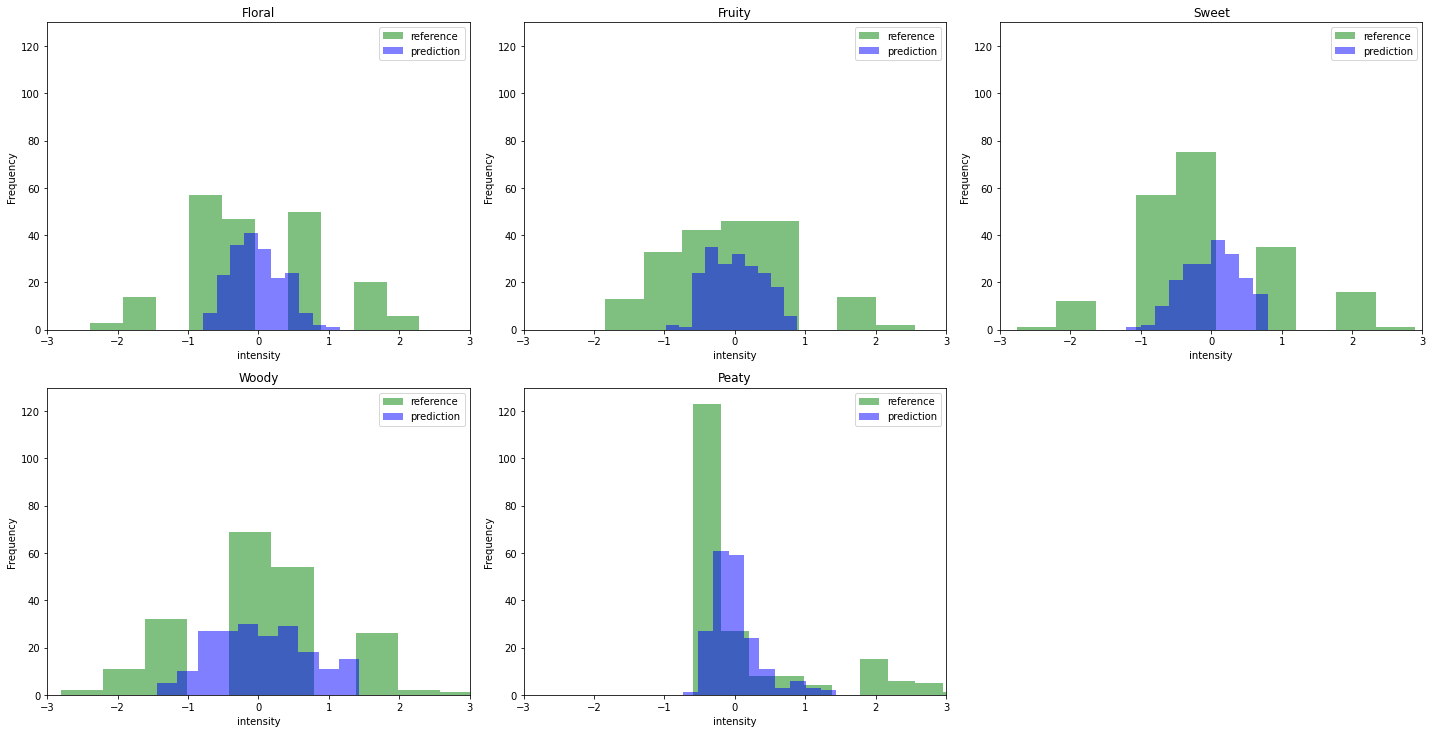

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
i = 0
for flavor in overlap_OSAs:
    i+=1

    plt.subplot(4,3,i)
    plt.hist(panelist_df_norm[flavor], color = 'g', alpha =0.5)
    plt.hist(results_all[flavor], color='b', alpha=0.5)
    labels= ["reference","prediction"]
    plt.legend(labels)
    plt.xlabel('intensity')
    plt.ylabel('Frequency')
    plt.title(flavor)
    
    plt.xlim(-3, 3)
    plt.ylim(0, 130)

plt.tight_layout()
plt.show()


In [58]:
def show_correlation_pred(prediction,reference,flavor):

    true_pos = (reference>0) & (pred>0)
    true_neg = (reference<=0) & (pred<=0)
    #false_pos  = (reference <= 0 ) & (pred>0)

    

    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    
    plt.hist(reference, color ='g', alpha = 0.5)
    plt.hist(prediction, alpha=0.5, color ='b')
    
    plt.xlim(-3, 3)
    plt.ylim(0, 130)

    labels= ["reference","prediction"]
    plt.legend(labels)

    plt.xlabel('intensity')
    plt.ylabel('Frequency')
    
    plt.subplot(1,2,2)
    plt.plot(prediction,reference,"o", color='b', alpha =0.5)
    
    plt.title("Correlation: "+ str(np.corrcoef(pd.to_numeric(prediction, errors='coerce').to_numpy(), np.array(reference))[0,1]))
    
    plt.xlim(-1.5,1.5)
    plt.ylim(-3,3)

    plt.suptitle(flavor)

    # Add text next to the plot
    text = ('True positive rate: ',
            np.sum(true_pos==True)/np.sum(pred>0), '\nTrue negative rate', np.sum(true_neg==True)/np.sum(pred<=0))

    plt.text(2, 0, '\n'.join(map(str, text)), fontsize=12, va='bottom', color='black')

    plt.show()

True in prediction 89
True in reference 76
True in both 38


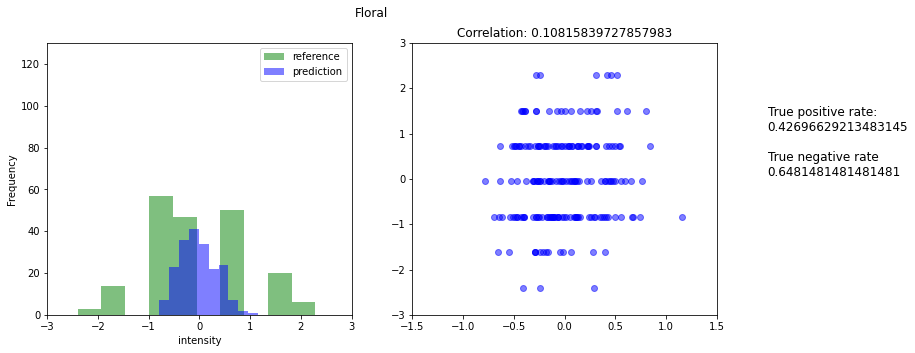

True in prediction 99
True in reference 109
True in both 56


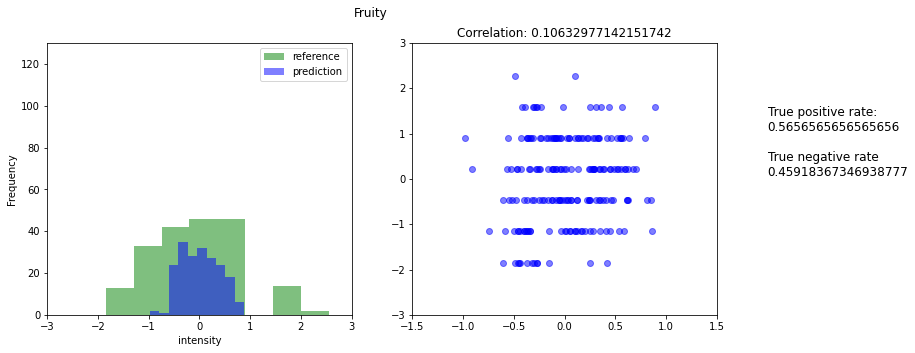

True in prediction 107
True in reference 127
True in both 73


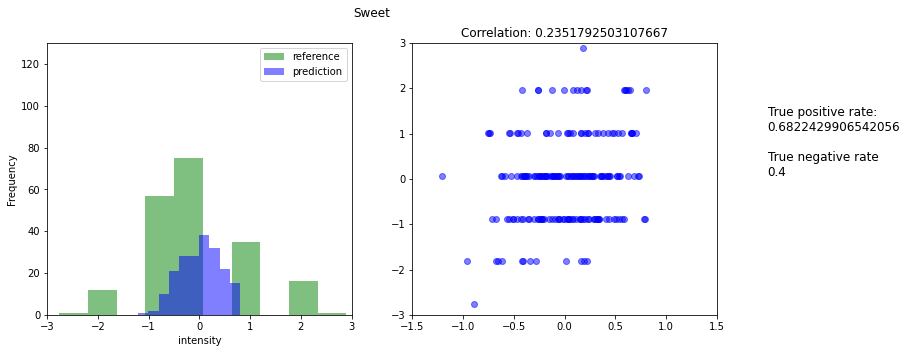

True in prediction 98
True in reference 83
True in both 51


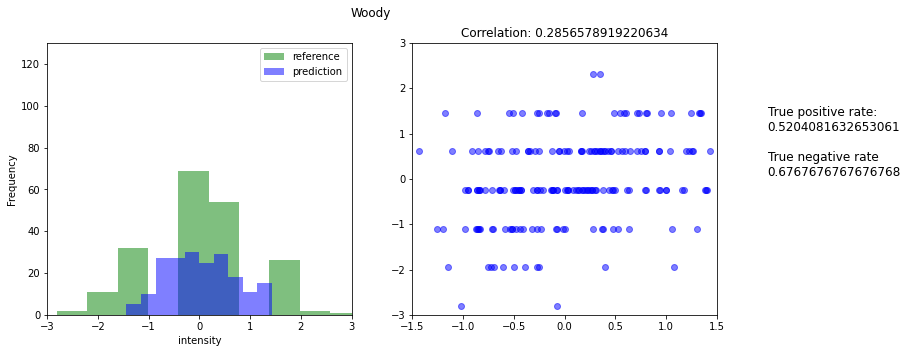

True in prediction 81
True in reference 47
True in both 39


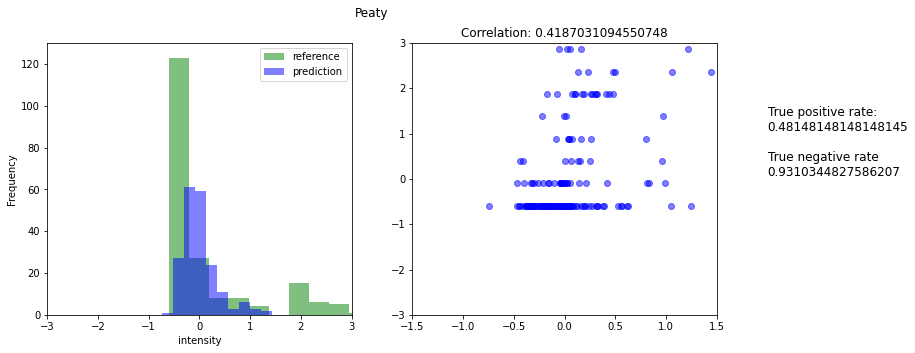

In [59]:
for flavor in overlap_OSAs:
    pred= results_all[flavor]
    #print(np.sum(pred>0),len(pred))
    reference=stats.zscore(panelist_df)[flavor]

    true_pos = (reference>0) & (pred>0)
    true_neg = (reference<=0) & (pred<=0)
    false_pos  = (reference <= 0 ) & (pred>0)

    print('True in prediction', np.sum(pred>0))
    print('True in reference', np.sum(reference>0))
    print('True in both', np.sum(true_pos==True))
    '''print( 'True positive rate',np.sum(true_pos==True)/np.sum(pred>0))
    print('False positive rate', np.sum(false_pos==True)/np.sum(pred>0))
    print( 'True negative rate', np.sum(true_neg==True)/np.sum(pred<=0))'''
    
    show_correlation_pred(pred, reference,flavor)
